In [5]:
import cellpose
import dask.array as da
import napari
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

### Load images from zarr 

In [2]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')

### Compress z-stacks into maximum projections

In [3]:
gfp = da.sum(gfp, axis = 1)
rfp = da.sum(rfp, axis = 1)

In [14]:
gfp

dask.array<sum-aggregate, shape=(75, 6048, 6048), dtype=uint64, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


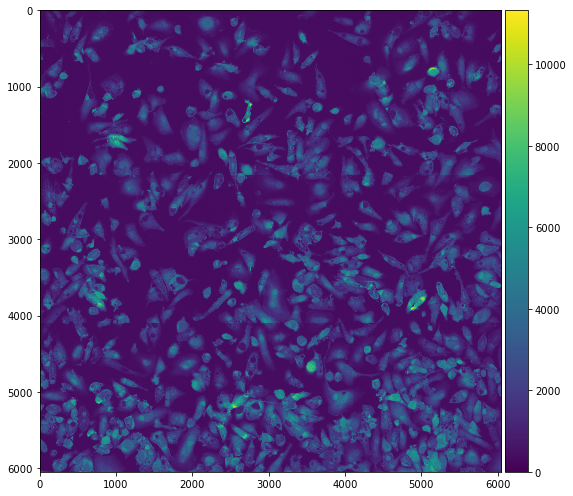

In [21]:
imshow(gfp[0])

## Save out first frame as tiff for testing default cellpose GUI on 

In [27]:
imsave('test.tiff', gfp[0])

/tmp/ipykernel_1206784/1145501843.py:1: UserWarning: test.tiff is a low contrast image
  imsave('test.tiff', gfp[0])


# Cellpose segmentation

Set up GPU usage

In [6]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Fri Aug 12 09:48:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   38C    P8    34W / 300W |   2352MiB / 49140MiB |     14%      Default |
|                               |                      |                  N/A |
+

### Define example 1ch gfp first ten frames max projection image

In [27]:
gfp

dask.array<sum-aggregate, shape=(75, 6048, 6048), dtype=uint64, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [28]:
%%time
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]
### define empty mask stack 
mask_stack = []
### iterate over frames
for frame in tqdm(gfp, total = len(gfp)):
    ### run segmentation
    masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)
    ### append to mask stack
    mask_stack.append(masks)

  0%|          | 0/75 [00:00<?, ?it/s]

CPU times: user 1h 17min 24s, sys: 16min 13s, total: 1h 33min 37s
Wall time: 1h 20min 18s


In [29]:
%time mask_stack = da.stack(mask_stack, axis = 0)

CPU times: user 4.56 s, sys: 2.03 ms, total: 4.56 s
Wall time: 4.56 s


In [30]:
mask_stack.to_zarr(f"/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr/", overwrite=False)

In [32]:
mask_stack

dask.array<stack, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>

In [33]:
v = napari.Viewer()
v.add_image(gfp, name="gfp", contrast_limits = [0,2352], blending = 'additive', colormap= 'green')
v.add_image(rfp, name="rfp", contrast_limits = [103,164], blending = 'additive', colormap = 'magenta')
v.add_labels(mask_stack, name = 'masks')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'masks' at 0x7f21034bc4f0>

# Testing different diameters

In [7]:
%%time
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]
### define empty mask stack 
mask_stack = []
### iterate over frames
for frame in tqdm(gfp, total = len(gfp)):
    ### run segmentation
    masks, flows, styles, diams = model.eval(frame, diameter=200, flow_threshold=None, channels=channels)
    ### append to mask stack
    mask_stack.append(masks)
mask_stack = da.stack(mask_stack, axis = 0)
#mask_stack.to_zarr(f"/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/test_diameter/tzxy_stack_d200_ch99.zarr/", overwrite=False)

  0%|          | 0/75 [00:00<?, ?it/s]

CPU times: user 16min 42s, sys: 5min 33s, total: 22min 15s
Wall time: 17min 59s


In [36]:
for diameter in tqdm([100, 125, 150, 175, 225, 250, 275, 300], total = 8):
    # define model_type='cyto' or model_type='nuclei'
    model = models.Cellpose(gpu=use_GPU, model_type='cyto')
    # define CHANNELS to run segementation on
    channels = [0,0]
    ### define empty mask stack 
    mask_stack = []
    ### iterate over frames
    for frame in tqdm(gfp, total = len(gfp)):
        ### run segmentation
        masks, flows, styles, diams = model.eval(frame, diameter=diameter, flow_threshold=None, channels=channels)
        ### append to mask stack
        mask_stack.append(masks)
    mask_stack = da.stack(mask_stack, axis = 0)
    mask_stack.to_zarr(f"/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/test_diameter/tzxy_stack_d{diameter}_ch99.zarr/", overwrite=False)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]